In [1]:
import xarray as xr

In [2]:
S7 = xr.load_dataset('/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel/S7_BT_in.nc')

In [3]:
S7

<xarray.Dataset>
Dimensions:                 (rows: 1200, columns: 1500, orphan_pixels: 187)
Dimensions without coordinates: rows, columns, orphan_pixels
Data variables:
    S7_BT_in                (rows, columns) float32 nan nan nan ... nan nan nan
    S7_BT_orphan_in         (rows, orphan_pixels) float32 285.3 283.6 ... nan
    S7_exception_in         (rows, columns) uint8 128 128 128 ... 128 128 128
    S7_exception_orphan_in  (rows, orphan_pixels) uint8 0 0 0 0 ... 128 128 128
Attributes: (12/16)
    absolute_orbit_number:  20407
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          20200119T034611Z
    history:                  2020-01-19T03:46:11Z: PUGCoreProcessor /data/ip...
    institution:            LN2
    ...                     ...
    source:                 IPF-SL-1 06.17
    start_offset:           27666
    start_time:             2020-01-17T22:14:15.241056Z
    stop_time:              2020-01-17T22:17:14.933329Z
    title:                  S3 SLSTR L1 Radiance and Brightness Temperatures ...
    track_offset:           998

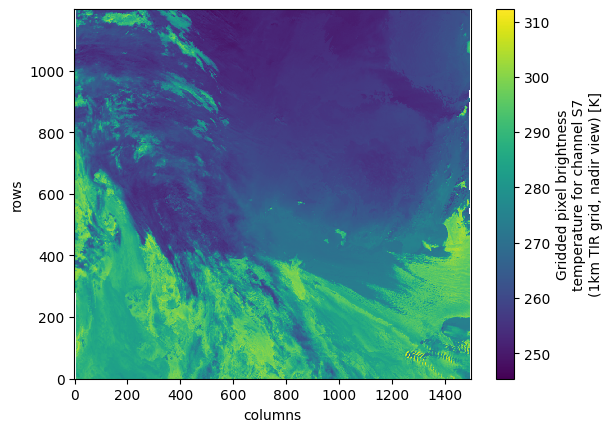

In [5]:
S7.S7_BT_in.plot()

In [6]:
S8 = xr.load_dataset('/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel/S8_BT_in.nc')

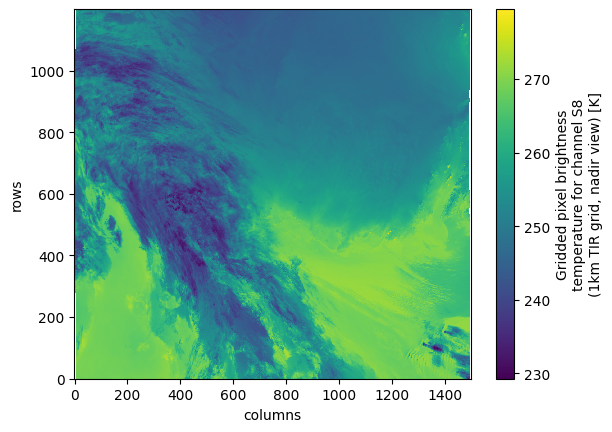

In [7]:
S8.S8_BT_in.plot()

1, 4, 8 for 3D plot of different channels
2(1),5,8

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def load_and_concat_datasets(parent_folder, channels):
    datasets = [
        xr.open_dataset(f'{parent_folder}/{channel}')[channel.split('.')[0]]
        for channel in channels
    ]
    ds_combined = xr.concat(datasets, dim='channels')
    return ds_combined

def find_min_max_across_channels(ds_combined):
    mins = [np.nanmin(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    maxs = [np.nanmax(ds_combined[i].values) for i in range(ds_combined.shape[0])]
    return np.nanmin(mins), np.nanmax(maxs)

def rescale_data(data, global_min, global_max):
    return 255 * (data - global_min) / (global_max - global_min)

def get_combined_labels(cloud, clear, ice):
    labels = np.zeros(cloud.shape[0], dtype=int)
    labels[cloud == 1] = 0  # 0 represents cloud
    labels[clear == 1] = 1  # 1 represents clear
    labels[ice == 1] = 2    # 2 represents ice
    return labels

def compute_initial_centroids(data, labels):
    unique_labels = np.unique(labels)
    initial_centroids = []

    for label in unique_labels:
        # Get data points corresponding to the current label
        label_data = data[labels == label]

        # Compute the mean feature vector for the label
        mean_vector = np.nanmean(label_data, axis=0)

        initial_centroids.append(mean_vector)

    return np.array(initial_centroids)

def perform_kmeans_and_evaluation(channels, parent_folder):
    ds_combined = load_and_concat_datasets(parent_folder, channels)

    global_min, global_max = find_min_max_across_channels(ds_combined)

    rescaled_data = xr.apply_ufunc(
        rescale_data,
        ds_combined,
        kwargs={'global_min': global_min, 'global_max': global_max},
        vectorize=True
    )

    n_samples = rescaled_data.shape[1] * rescaled_data.shape[2]
    n_features = rescaled_data.shape[0]
    rescaled_array = rescaled_data.values.reshape(n_samples, n_features)

    nan_mask = np.isnan(rescaled_array)
    rescaled_array_clean = rescaled_array[~nan_mask.any(axis=1)]

    cloud_labels = xr.open_dataset(f'{parent_folder}/cloud_labels.nc')['Cloud']
    clear_labels = xr.open_dataset(f'{parent_folder}/clear_labels.nc')['Clear']
    ice_labels = xr.open_dataset(f'{parent_folder}/ice_labels.nc')['Ice']

    cloud_labels_flat = cloud_labels.values.flatten()
    clear_labels_flat = clear_labels.values.flatten()
    ice_labels_flat = ice_labels.values.flatten()
    combined_labels_flat = get_combined_labels(cloud_labels_flat, clear_labels_flat, ice_labels_flat)

    # Compute initial centroids
    initial_centroids = compute_initial_centroids(rescaled_array_clean, combined_labels_flat[~nan_mask.any(axis=1)])

    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids).fit(rescaled_array_clean)
    cluster_labels_clean = np.full(n_samples, np.nan)
    cluster_labels_clean[~nan_mask.any(axis=1)] = kmeans.labels_

    labels_common_mask = ~np.isnan(cluster_labels_clean) & \
                         ~np.isnan(cloud_labels_flat) & \
                         ~np.isnan(clear_labels_flat) & \
                         ~np.isnan(ice_labels_flat)

    combined_labels_clean_filtered = combined_labels_flat[labels_common_mask]
    cluster_labels_clean_filtered = cluster_labels_clean[labels_common_mask]

    conf_matrix = confusion_matrix(combined_labels_clean_filtered, cluster_labels_clean_filtered)
    accuracy = accuracy_score(combined_labels_clean_filtered, cluster_labels_clean_filtered)

    display_results(conf_matrix, accuracy, 'Combined')

    return ds_combined, cluster_labels_clean.reshape(ds_combined.shape[1:]), cloud_labels, clear_labels, ice_labels, kmeans, rescaled_array_clean

def display_results(matrix, accuracy, label_name):
    df = pd.DataFrame(matrix, 
                      columns=[f"Predicted {i}" for i in range(matrix.shape[1])], 
                      index=[f"Actual {i}" for i in range(matrix.shape[0])])
    print(f"Confusion Matrix - {label_name} Labels:")
    print(df)
    print(f"Accuracy - {label_name} Labels:", accuracy)
    print("\n" + "="*50 + "\n")

channels_radiance = ['S1_radiance_in.nc', 'S2_radiance_in.nc', 'S3_radiance_in.nc', 'S4_radiance_in.nc', 'S5_radiance_in.nc', 'S6_radiance_in.nc']
channels_thermal = ['S7_BT_in.nc', 'S8_BT_in.nc', 'S9_BT_in.nc']
channels = channels_radiance + channels_thermal

ds_combined, cluster_labels_clean, combined_labels, _, _, kmeans, rescaled_array_clean = perform_kmeans_and_evaluation(channels, '/Users/rashmilsinha/Downloads/Sentinel-lite/sentinel/')


/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/rashmilsinha/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


Confusion Matrix - Combined Labels:
          Predicted 0  Predicted 1  Predicted 2
Actual 0       839857       601003       334516
Actual 1            0          309           11
Actual 2            0         1813          882
Accuracy - Combined Labels: 0.4729263699602618


